<a href="https://colab.research.google.com/github/kridtapon/Volatility-Momentum-Strategy/blob/main/Volatility_Momentum_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.4/527.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninst

In [40]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Calculate MACD and Signal Line
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    """Calculate MACD and Signal Line."""
    fast_ema = df['Close'].ewm(span=fast_period, min_periods=fast_period).mean()
    slow_ema = df['Close'].ewm(span=slow_period, min_periods=slow_period).mean()
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal_period, min_periods=signal_period).mean()
    return macd, signal

# Calculate ATR (Average True Range)
def calculate_atr(df, period=14):
    """Calculate the Average True Range (ATR)."""
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = (df['High'] - df['Close'].shift()).abs()
    df['Low-Close'] = (df['Low'] - df['Close'].shift()).abs()
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    atr = df['TrueRange'].rolling(window=period).mean()
    return atr

# Define the stock symbol and time period
symbol = 'INTC'
start_date = '2014-12-24'
end_date = '2024-12-24'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate MACD, Signal, and ATR
df['MACD'], df['Signal'] = calculate_macd(df, fast_period=10, slow_period=28, signal_period=12)
df['ATR'] = calculate_atr(df, period=20)

# Define entry and exit signals based on MACD and ATR
df['Entry'] = (
    (df['MACD'] > df['Signal']) &  # MACD crosses above Signal Line
    (df['MACD'].shift(1) < df['Signal'].shift(1)) &  # Previous MACD was below Signal
    (df['ATR'] > df['ATR'].shift(1))  # ATR is rising (volatility increasing)
)

df['Exit'] = (
    (df['MACD'] < df['Signal']) &  # MACD crosses below Signal Line
    (df['MACD'].shift(1) > df['Signal'].shift(1)) &  # Previous MACD was above Signal
    (df['ATR'] < df['ATR'].shift(1))  # ATR is falling (volatility decreasing)
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2014-12-24 00:00:00
End                           2024-12-23 00:00:00
Period                                       2516
Start Value                              100000.0
End Value                            177277.75589
Total Return [%]                        77.277756
Benchmark Return [%]                   -46.047005
Max Gross Exposure [%]                      100.0
Total Fees Paid                       6582.826444
Max Drawdown [%]                        39.096725
Max Drawdown Duration                       933.0
Total Trades                                   23
Total Closed Trades                            23
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            52.173913
Best Trade [%]                           50.28961
Worst Trade [%]                        -11.772527
Avg Winning Trade [%]                    10.44151
Avg Losing Trade [%]                    -4.696727


In [42]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.7 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


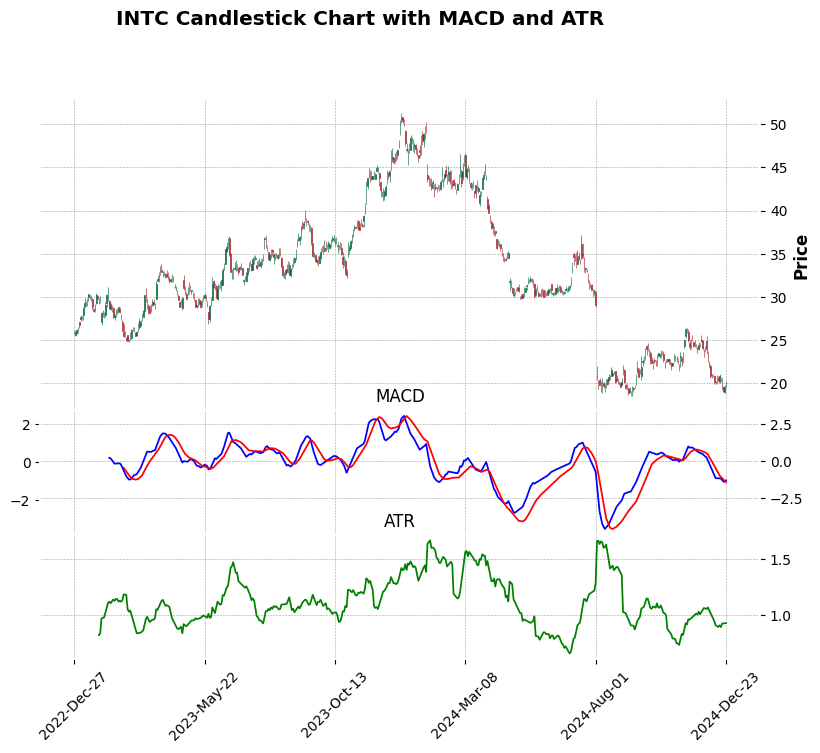

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf

# Calculate MACD and Signal Line
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    """Calculate MACD and Signal Line."""
    fast_ema = df['Close'].ewm(span=fast_period, min_periods=fast_period).mean()
    slow_ema = df['Close'].ewm(span=slow_period, min_periods=slow_period).mean()
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal_period, min_periods=signal_period).mean()
    return macd, signal

# Calculate ATR (Average True Range)
def calculate_atr(df, period=14):
    """Calculate the Average True Range (ATR)."""
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = (df['High'] - df['Close'].shift()).abs()
    df['Low-Close'] = (df['Low'] - df['Close'].shift()).abs()
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    atr = df['TrueRange'].rolling(window=period).mean()
    return atr

# Define the stock symbol and time period
symbol = 'INTC'
start_date = '2022-12-24'
end_date = '2024-12-24'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate MACD, Signal, and ATR
df['MACD'], df['Signal'] = calculate_macd(df, fast_period=10, slow_period=28, signal_period=12)
df['ATR'] = calculate_atr(df, period=20)

# Create additional plots for MACD and ATR
macd_plot = mpf.make_addplot(df['MACD'], panel=1, color='blue', title='MACD')
signal_plot = mpf.make_addplot(df['Signal'], panel=1, color='red')
atr_plot = mpf.make_addplot(df['ATR'], panel=2, color='green', title='ATR')

# Create the candlestick chart with indicators
mpf.plot(df, type='candle', addplot=[macd_plot, signal_plot, atr_plot], figsize=(10, 8),
         title=f'{symbol} Candlestick Chart with MACD and ATR', style='charles')

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



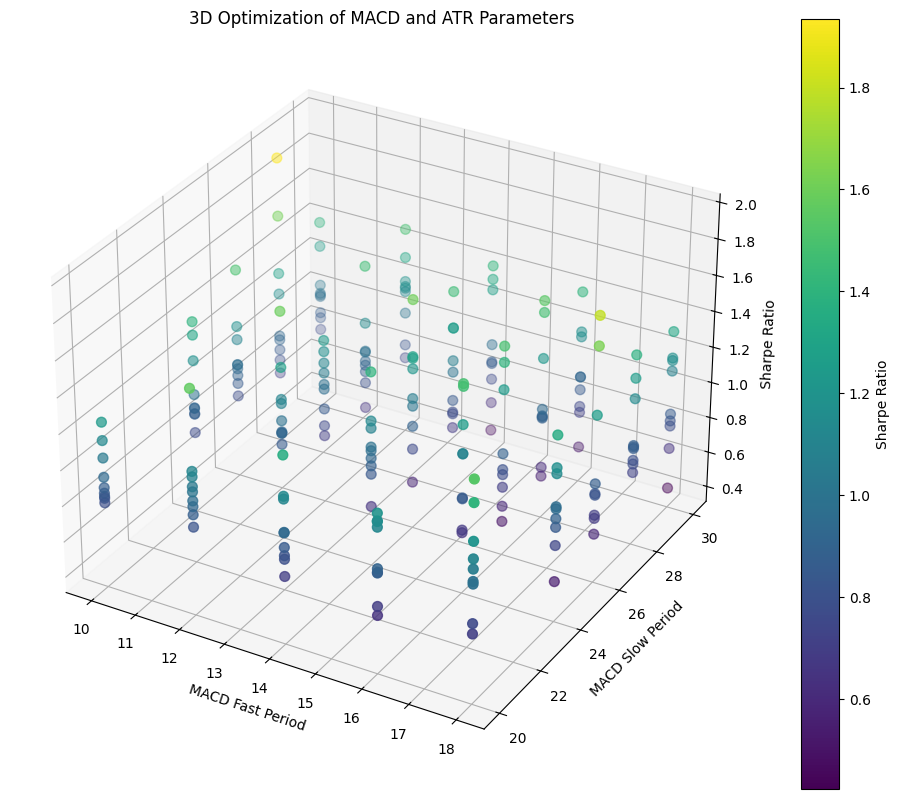

Best MACD Fast Period: 10, Best MACD Slow Period: 28, Best MACD Signal Period: 12, Best ATR Period: 20
Start                         2015-01-02 00:00:00
End                           2024-12-20 00:00:00
Period                                       2510
Start Value                              100000.0
End Value                            177277.75589
Total Return [%]                        77.277756
Benchmark Return [%]                   -46.314631
Max Gross Exposure [%]                      100.0
Total Fees Paid                       6582.826444
Max Drawdown [%]                        39.096725
Max Drawdown Duration                       932.0
Total Trades                                   23
Total Closed Trades                            23
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            52.173913
Best Trade [%]                           50.28961
Worst Trade [%]                        -11.7725

In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting

# Function to calculate MACD and Signal line
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    """Calculate MACD and Signal line."""
    macd = df['Close'].ewm(span=fast_period, adjust=False).mean() - df['Close'].ewm(span=slow_period, adjust=False).mean()
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

# Function to calculate ATR (Average True Range)
def calculate_atr(df, period=14):
    """Calculate Average True Range (ATR)."""
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift(1))
    low_close = np.abs(df['Low'] - df['Close'].shift(1))
    true_range = np.maximum(high_low, np.maximum(high_close, low_close))
    atr = true_range.rolling(window=period).mean()
    return atr

# Define the stock symbol and time period
symbol = 'INTC'
start_date = '2015-01-01'
end_date = '2024-12-23'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Define parameter ranges for optimization
macd_fast_periods = [10, 12, 14, 16, 18]
macd_slow_periods = [20, 24, 26, 28, 30]
macd_signal_periods = [6, 9, 12]
atr_periods = [10, 14, 20]

# Lists to hold optimization results
sharpe_ratios = []
macd_fast_list = []
macd_slow_list = []
macd_signal_list = []
atr_list = []

# Loop through different parameter combinations
for macd_fast in macd_fast_periods:
    for macd_slow in macd_slow_periods:
        for macd_signal in macd_signal_periods:
            for atr_period in atr_periods:
                # Calculate MACD and ATR for the current parameters
                macd, signal = calculate_macd(df, fast_period=macd_fast, slow_period=macd_slow, signal_period=macd_signal)
                atr = calculate_atr(df, period=atr_period)

                # Define entry signal: MACD crosses above Signal line and ATR is rising
                df['Entry'] = (
                    (macd > signal) &  # MACD crosses above Signal
                    (macd.shift(1) < signal.shift(1)) &  # Previous MACD was below Signal
                    (atr > atr.shift(1))  # ATR is rising (increasing volatility)
                )

                # Define exit signal: MACD crosses below Signal line and ATR is falling
                df['Exit'] = (
                    (macd < signal) &  # MACD crosses below Signal
                    (macd.shift(1) > signal.shift(1)) &  # Previous MACD was above Signal
                    (atr < atr.shift(1))  # ATR is falling (decreasing volatility)
                )

                # Convert signals to boolean arrays
                entries = df['Entry'].to_numpy()
                exits = df['Exit'].to_numpy()

                # Backtest using vectorbt
                portfolio = vbt.Portfolio.from_signals(
                    close=df['Close'],
                    entries=entries,
                    exits=exits,
                    init_cash=100_000,
                    fees=0.001
                )

                # Get Sharpe ratio for the current parameter combination
                sharpe_ratio = portfolio.stats()['Profit Factor']

                # Append results to lists
                sharpe_ratios.append(sharpe_ratio)
                macd_fast_list.append(macd_fast)
                macd_slow_list.append(macd_slow)
                macd_signal_list.append(macd_signal)
                atr_list.append(atr_period)

# Convert results to numpy arrays
sharpe_ratios = np.array(sharpe_ratios)
macd_fast_list = np.array(macd_fast_list)
macd_slow_list = np.array(macd_slow_list)
macd_signal_list = np.array(macd_signal_list)
atr_list = np.array(atr_list)

# Create a 3D scatter plot of the Sharpe ratios
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
scatter = ax.scatter(macd_fast_list, macd_slow_list, sharpe_ratios, c=sharpe_ratios, cmap='viridis', s=50)
ax.set_xlabel('MACD Fast Period')
ax.set_ylabel('MACD Slow Period')
ax.set_zlabel('Sharpe Ratio')

# Add color bar
fig.colorbar(scatter, label='Sharpe Ratio')

# Title and display the plot
plt.title('3D Optimization of MACD and ATR Parameters')
plt.show()

# Find the best parameters based on the highest Sharpe ratio
best_index = np.argmax(sharpe_ratios)
best_macd_fast = macd_fast_list[best_index]
best_macd_slow = macd_slow_list[best_index]
best_macd_signal = macd_signal_list[best_index]
best_atr_period = atr_list[best_index]

print(f"Best MACD Fast Period: {best_macd_fast}, Best MACD Slow Period: {best_macd_slow}, Best MACD Signal Period: {best_macd_signal}, Best ATR Period: {best_atr_period}")

# Calculate MACD, Signal, and ATR with the best parameters
macd, signal = calculate_macd(df, fast_period=best_macd_fast, slow_period=best_macd_slow, signal_period=best_macd_signal)
atr = calculate_atr(df, period=best_atr_period)

# Define entry and exit signals
df['Entry'] = (
    (macd > signal) &  # MACD crosses above Signal
    (macd.shift(1) < signal.shift(1)) &  # Previous MACD was below Signal
    (atr > atr.shift(1))  # ATR is rising
)
df['Exit'] = (
    (macd < signal) &  # MACD crosses below Signal
    (macd.shift(1) > signal.shift(1)) &  # Previous MACD was above Signal
    (atr < atr.shift(1))  # ATR is falling
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()
